In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
# Load the required files
X_train = pd.read_csv('./X_train.csv')
X_test = pd.read_csv('./X_test.csv')
y_train = pd.read_csv('./y_train.csv')
y_test = pd.read_csv('./y_test.csv')
X_ros = pd.read_csv('./X_ros.csv')
y_ros = pd.read_csv('./y_ros.csv')

In [3]:
X_train.drop('Unnamed: 0', axis=1, inplace=True)
X_test.drop('Unnamed: 0', axis=1, inplace=True)
y_train.drop('Unnamed: 0', axis=1, inplace=True)
y_test.drop('Unnamed: 0', axis=1, inplace=True)
X_ros.drop('Unnamed: 0', axis=1, inplace=True)
y_ros.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc, average_precision_score

In [5]:
# Defining functions to plot AUROC curve, Precision-Recall Curve, Recall-Precision Curve

def auroc(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=[8,8])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic: is_early_readmit', fontsize=18)
    plt.legend(loc="lower right")
    return plt


def precision_recall(y_test, y_pred):
    average_precision = average_precision_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    plt.step(recall, precision, color='g', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='g')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    return plt
    

def recall_precision(y_test, y_pred):
    average_precision = average_precision_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    
    plt.step(precision, recall, color='g', alpha=0.2, where='post')
    plt.fill_between(precision, recall, step='post', alpha=0.2,
                 color='g')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Recall-Precision curve: AP={0:0.2f}'.format(average_precision))
    return plt

In [6]:
# Defining functions to plot Learning Curve to diagnose Model Bias or Variance

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### LogisticRegression

In [7]:
# Fitting LogisticRegression
lr1 = LogisticRegressionCV(Cs=np.logspace(0,10,100), cv=5, penalty='l1', solver='liblinear', n_jobs=-1, random_state=12)
lr2 = LogisticRegressionCV(Cs=np.logspace(0,10,100), cv=5, penalty='l2', solver='liblinear', n_jobs=-1, random_state=12)

In [8]:
# With Lasso penalty
lr1.fit(X_ros, y_ros['readmitted'])
print(lr1.score(X_ros, y_ros['readmitted']))
print(lr1.score(X_test, y_test['readmitted']))
y_pred1 = lr1.predict(X_test)

0.613657763021
0.609195402299


In [9]:
#Best 'C' parameter
lr1.C_

array([ 1.])

In [10]:
# Confusion matrix
conmat = np.array(confusion_matrix(y_test, y_pred1, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['is_early_readmit', 'not_early_readmit'],
                         columns=['predicted_early_readmit','predicted_not_early_readmit'])
confusion

,predicted_early_readmit,predicted_not_early_readmit
is_early_readmit,230,187
not_early_readmit,1683,2685


In [11]:
print(classification_report(y_test['readmitted'], y_pred1))

             precision    recall  f1-score   support

          0       0.93      0.61      0.74      4368
          1       0.12      0.55      0.20       417

avg / total       0.86      0.61      0.69      4785



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

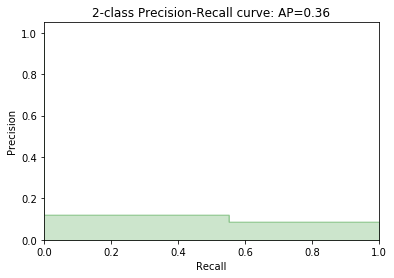

In [12]:
# Precision-Recall Curve
precision_recall(y_test, y_pred1)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

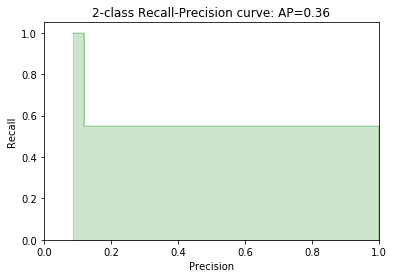

In [13]:
# Recall-Precision Curve
recall_precision(y_test, y_pred1)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

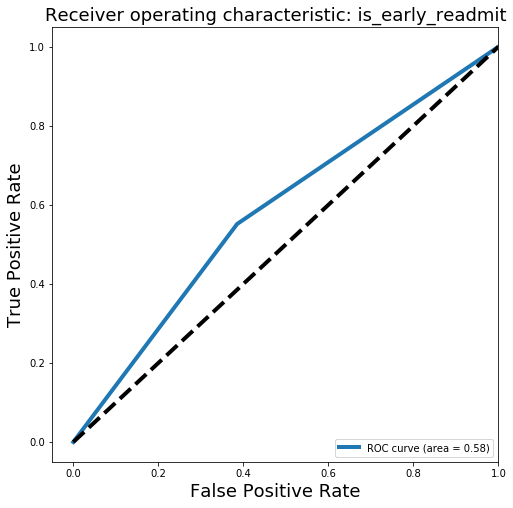

In [14]:
# AUROC curve
auroc(y_test, y_pred1)

In [15]:
# Importance of Coefficients
coefs = pd.DataFrame(data={'Features':X_ros.columns, 'Coefficients':list(lr1.coef_[0])})

In [16]:
coefs.sort_values('Coefficients', ascending=False)

,Coefficients,Features
4,4.068422,number_emergency
5,3.724272,number_inpatient
0,0.968762,time_in_hospital
22,0.886071,age_[70-80)
21,0.881042,age_[60-70)
23,0.606120,age_[80-90)
19,0.540750,age_[40-50)
28,0.450382,discharge_disposition_id_3
18,0.422926,age_[30-40)
26,0.411134,admission_type_id_5


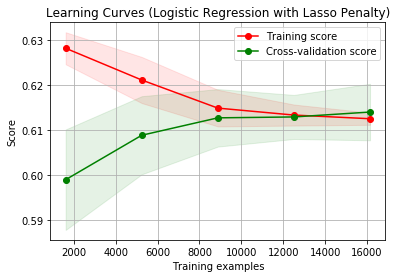

In [17]:
# Plot Learning Curve to diagnose Model Bias or Variance
title = "Learning Curves (Logistic Regression with Lasso Penalty)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=12)

estimator = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, n_jobs=-1, verbose=1, random_state=12)
plot_learning_curve(estimator, title, X_ros, y_ros['readmitted'], cv=cv, n_jobs=-1)


plt.show()

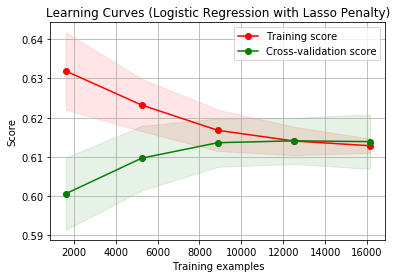

In [18]:
# Plot Learning Curve to diagnose Model Bias or Variance
title = "Learning Curves (Logistic Regression with Lasso Penalty)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=12)

estimator = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, n_jobs=-1, verbose=1, random_state=12)
plot_learning_curve(estimator, title, X_ros, y_ros['readmitted'], cv=cv, n_jobs=-1)


plt.show()

In [19]:
# With Ridge penalty
lr2.fit(X_ros, y_ros['readmitted'])
print(lr2.score(X_ros, y_ros['readmitted']))
print(lr2.score(X_test, y_test['readmitted']))
y_pred2 = lr2.predict(X_test)

0.614252440656
0.607941483804


In [20]:
# Best 'C' parameter
lr2.C_

array([ 1.59228279])

In [21]:
# Confusion matrix
conmat2 = np.array(confusion_matrix(y_test, y_pred2, labels=[1,0]))

confusion2 = pd.DataFrame(conmat2, index=['is_early_readmit', 'not_early_readmit'],
                         columns=['predicted_early_readmit','predicted_not_early_readmit'])
confusion2

,predicted_early_readmit,predicted_not_early_readmit
is_early_readmit,230,187
not_early_readmit,1689,2679


In [22]:
print(classification_report(y_test['readmitted'], y_pred2))

             precision    recall  f1-score   support

          0       0.93      0.61      0.74      4368
          1       0.12      0.55      0.20       417

avg / total       0.86      0.61      0.69      4785



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

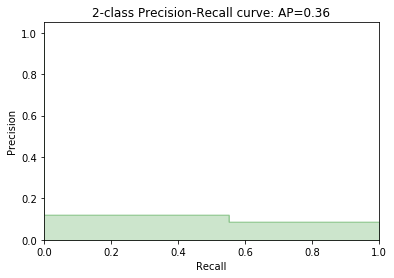

In [23]:
# Precision-Recall Curve
precision_recall(y_test, y_pred2)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

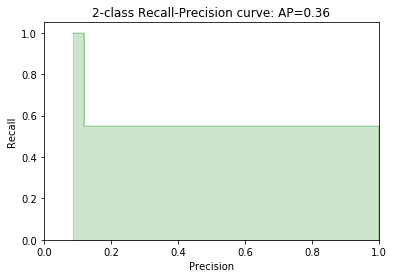

In [24]:
# Recall-Precision Curve
recall_precision(y_test, y_pred2)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

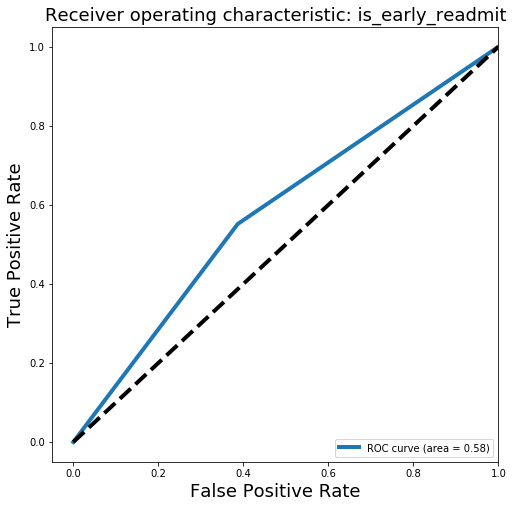

In [25]:
# AUROC curve
auroc(y_test, y_pred2)

In [26]:
# Importance of Coefficients
coefs = pd.DataFrame(data={'Features':X_ros.columns, 'Coefficients':list(lr2.coef_[0])})
coefs.sort_values('Coefficients', ascending=False)

,Coefficients,Features
4,3.765635,number_emergency
5,3.663728,number_inpatient
0,0.966953,time_in_hospital
22,0.905556,age_[70-80)
21,0.900245,age_[60-70)
23,0.626350,age_[80-90)
19,0.563690,age_[40-50)
28,0.452891,discharge_disposition_id_3
18,0.447170,age_[30-40)
26,0.413854,admission_type_id_5


### RandomForest

In [27]:
rfc1 = RandomForestClassifier(n_estimators=50,max_features=10, criterion='gini', max_depth=3,n_jobs=-1,verbose=1, random_state=12)

In [28]:
rfc1.fit(X_ros, y_ros['readmitted'])
print(rfc1.score(X_ros, y_ros['readmitted']))
print(rfc1.score(X_test, y_test['readmitted']))
y_pred3 = rfc1.predict(X_test)
print(classification_report(y_test, y_pred3))

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.1s finished


0.703354972992
0.641170323929
             precision    recall  f1-score   support

          0       0.92      0.66      0.77      4368
          1       0.11      0.42      0.17       417

avg / total       0.85      0.64      0.72      4785



[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished


In [29]:
# Confusion matrix
conmat3 = np.array(confusion_matrix(y_test, y_pred3, labels=[1,0]))

confusion3 = pd.DataFrame(conmat3, index=['is_early_readmit', 'not_early_readmit'],
                         columns=['predicted_early_readmit','predicted_not_early_readmit'])
confusion3

,predicted_early_readmit,predicted_not_early_readmit
is_early_readmit,176,241
not_early_readmit,1476,2892


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

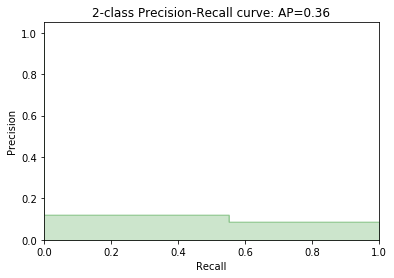

In [30]:
# Precision-Recall Curve
precision_recall(y_test, y_pred2)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

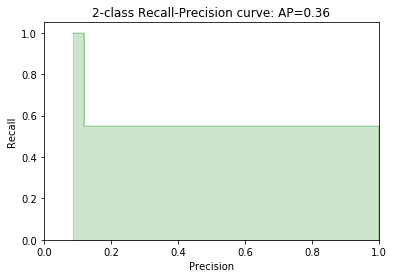

In [31]:
# Recall-Precision Curve
recall_precision(y_test, y_pred2)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

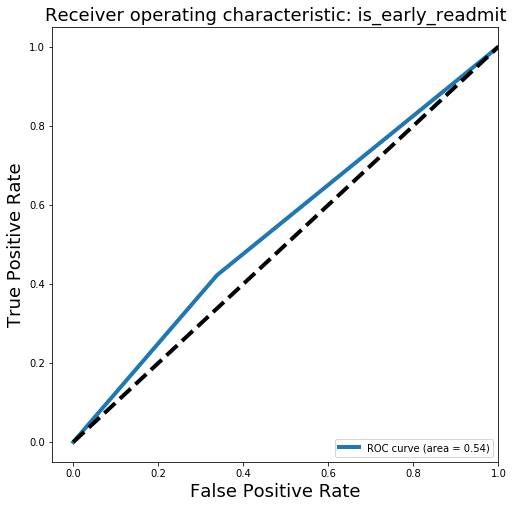

In [32]:
# AUROC curve
auroc(y_test, y_pred3)

In [33]:
# Feature Importance
coefs = pd.DataFrame(data={'Features':X_ros.columns, 'Importance':list(rfc1.feature_importances_)})
coefs.sort_values('Importance', ascending=False)

,Features,Importance
0,time_in_hospital,0.240452
20,age_[50-60),0.152445
16,race_Caucasian,0.129067
28,discharge_disposition_id_3,0.110352
5,number_inpatient,0.109755
2,num_procedures,0.093021
21,age_[60-70),0.036792
11,glipizide,0.020614
4,number_emergency,0.012916
25,admission_type_id_3,0.011667


### XGBOOST

In [34]:
X_ros.columns = X_ros.columns.str.replace('-','_')
X_ros.columns = X_ros.columns.str.replace('[','(')

In [35]:
X_test.columns = X_test.columns.str.replace('-','_')
X_test.columns = X_test.columns.str.replace('[','(')

In [36]:
xgb1 = XGBClassifier(booster='gblinear', reg_alpha=1, learning_rate=0.15, scale_pos_weight=1.2, random_state=12, n_jobs=-1)
xgb1.fit(X_ros, y_ros['readmitted'])
print(xgb1.score(X_ros, y_ros['readmitted']))
print(xgb1.score(X_test, y_test['readmitted']))
y_pred4 = xgb1.predict(X_test)

0.609594132514
0.481922675026


In [37]:
# Confusion matrix
conmat4 = np.array(confusion_matrix(y_test, y_pred4, labels=[1,0]))

confusion4 = pd.DataFrame(conmat4, index=['is_early_readmit', 'not_early_readmit'],
                         columns=['predicted_early_readmit','predicted_not_early_readmit'])
confusion4

,predicted_early_readmit,predicted_not_early_readmit
is_early_readmit,285,132
not_early_readmit,2347,2021


In [38]:
print(classification_report(y_test, y_pred4))

             precision    recall  f1-score   support

          0       0.94      0.46      0.62      4368
          1       0.11      0.68      0.19       417

avg / total       0.87      0.48      0.58      4785



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

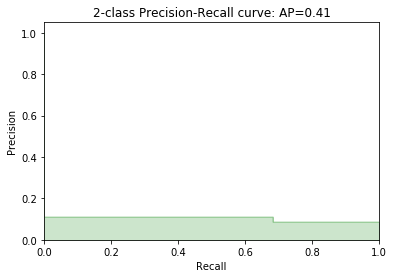

In [39]:
# Precision-Recall Curve
precision_recall(y_test, y_pred4)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

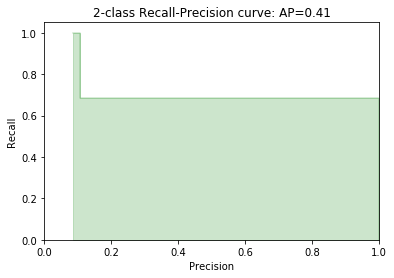

In [40]:
# Recall-Precision Curve
recall_precision(y_test, y_pred4)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

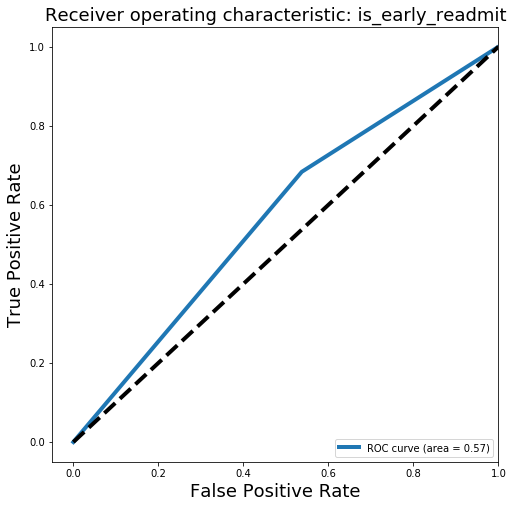

In [41]:
auroc(y_test, y_pred4)

In [42]:
xgb2 = XGBClassifier(booster='gblinear', reg_alpha=1, learning_rate=0.15, missing=0, random_state=12, n_jobs=-1)
xgb2.fit(X_ros, y_ros['readmitted'])
print(xgb2.score(X_ros, y_ros['readmitted']))
print(xgb2.score(X_test, y_test['readmitted']))
y_pred5 = xgb2.predict(X_test)

0.614698448883
0.607314524556


In [43]:
conmat5 = np.array(confusion_matrix(y_test, y_pred5, labels=[1,0]))

confusion = pd.DataFrame(conmat5, index=['is_early_readmit', 'not_early_readmit'],
                         columns=['predicted_early_readmit','predicted_not_early_readmit'])
confusion

,predicted_early_readmit,predicted_not_early_readmit
is_early_readmit,240,177
not_early_readmit,1702,2666


In [44]:
print(classification_report(y_test, y_pred5))

             precision    recall  f1-score   support

          0       0.94      0.61      0.74      4368
          1       0.12      0.58      0.20       417

avg / total       0.87      0.61      0.69      4785



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

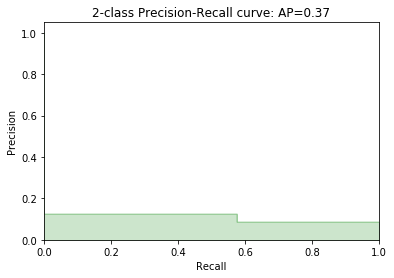

In [45]:
# Precision-Recall Curve
precision_recall(y_test, y_pred5)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

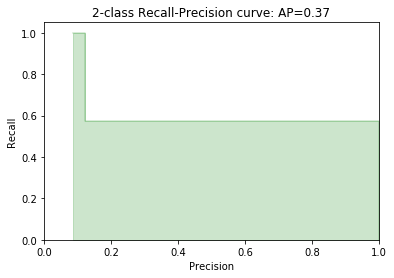

In [46]:
# Recall-Precision Curve
recall_precision(y_test, y_pred5)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

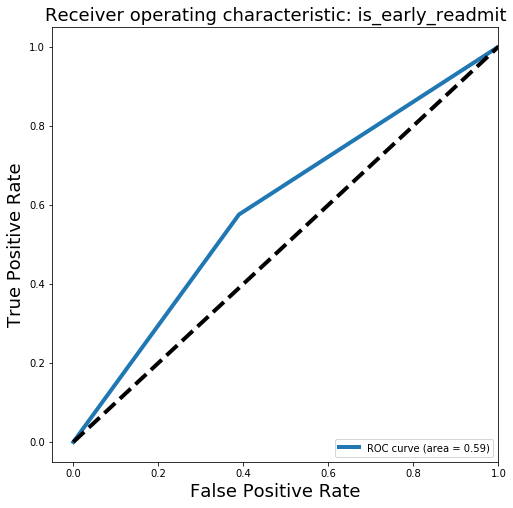

In [47]:
auroc(y_test, y_pred5)

### Deep Learning

In [48]:
# DeepLearning Try 1
#https://keras.io/getting-started/sequential-model-guide/

In [49]:
# MLP for binary classification:

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

'''# Generate dummy data
x_train = np.random.random((1000, 20))
y_train = np.random.randint(2, size=(1000, 1))
x_test = np.random.random((100, 20))
y_test = np.random.randint(2, size=(100, 1))'''

model = Sequential()
model.add(Dense(64, input_dim=39, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(np.array(X_ros), np.array(y_ros['readmitted']),
          epochs=100,
          batch_size=128)
score = model.evaluate(np.array(X_test), np.array(y_test['readmitted']), batch_size=128)

Using TensorFlow backend.


Epoch 1/100
20179/20179 [==============================] - 0s - loss: 0.7100 - acc: 0.5193     
Epoch 2/100
20179/20179 [==============================] - 0s - loss: 0.6839 - acc: 0.5533     
Epoch 3/100
20179/20179 [==============================] - 0s - loss: 0.6740 - acc: 0.5796     
Epoch 4/100
20179/20179 [==============================] - 0s - loss: 0.6610 - acc: 0.6044     
Epoch 5/100
20179/20179 [==============================] - 0s - loss: 0.6495 - acc: 0.6223     
Epoch 6/100
20179/20179 [==============================] - 0s - loss: 0.6394 - acc: 0.6367     
Epoch 7/100
20179/20179 [==============================] - 0s - loss: 0.6249 - acc: 0.6543     
Epoch 8/100
20179/20179 [==============================] - 0s - loss: 0.6148 - acc: 0.6647     
Epoch 9/100
20179/20179 [==============================] - 0s - loss: 0.5999 - acc: 0.6795     
Epoch 10/100
20179/20179 [==============================] - 0s - loss: 0.5914 - acc: 0.6851     
Epoch 11/100
20179/20179 [=============

20179/20179 [==============================] - 0s - loss: 0.4085 - acc: 0.8198     
Epoch 86/100
20179/20179 [==============================] - 0s - loss: 0.4041 - acc: 0.8250     
Epoch 87/100
20179/20179 [==============================] - 0s - loss: 0.4017 - acc: 0.8255     
Epoch 88/100
20179/20179 [==============================] - 0s - loss: 0.4007 - acc: 0.8251     
Epoch 89/100
20179/20179 [==============================] - 0s - loss: 0.4031 - acc: 0.8253     
Epoch 90/100
20179/20179 [==============================] - 0s - loss: 0.4064 - acc: 0.8222     
Epoch 91/100
20179/20179 [==============================] - 0s - loss: 0.4079 - acc: 0.8193     
Epoch 92/100
20179/20179 [==============================] - 0s - loss: 0.4033 - acc: 0.8218     
Epoch 93/100
20179/20179 [==============================] - 0s - loss: 0.4048 - acc: 0.8243     
Epoch 94/100
20179/20179 [==============================] - 0s - loss: 0.3989 - acc: 0.8265     
Epoch 95/100
20179/20179 [=================

In [50]:
y_pred6 = model.predict(np.array(X_test))

In [51]:
y_pred6 = pd.DataFrame(data={'predicted_prob':list(y_pred6)})

In [52]:
# Function to convert from predicted probs to actual class values
def convert(data):
    data = data[0]
    if data >=0.5:
        return 1
    else:
        return 0

In [53]:
y_pred6['predicted_prob'] = y_pred6['predicted_prob'].apply(convert)

In [54]:
print(classification_report(y_test['readmitted'], y_pred6['predicted_prob']))

             precision    recall  f1-score   support

          0       0.92      0.80      0.86      4368
          1       0.11      0.24      0.15       417

avg / total       0.85      0.75      0.79      4785



In [55]:
conmat6 = np.array(confusion_matrix(y_test, y_pred6['predicted_prob'], labels=[1,0]))

confusion = pd.DataFrame(conmat6, index=['is_early_readmit', 'not_early_readmit'],
                         columns=['predicted_early_readmit','predicted_not_early_readmit'])
confusion

,predicted_early_readmit,predicted_not_early_readmit
is_early_readmit,102,315
not_early_readmit,868,3500


In [56]:
# Deep Learning Try2
# https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

In [57]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [58]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [59]:
# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(60, input_dim=39, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [60]:
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, nb_epoch=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(estimator, np.array(X_ros), np.array(y_ros['readmitted']), cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 82.75% (1.00%)


In [61]:
dd = estimator.fit(np.array(X_ros), np.array(y_ros['readmitted']))

In [62]:
y_pred7 = dd.model.predict(np.array(X_test))

In [63]:
y_pred7 = pd.DataFrame(data={'predicted_prob':list(y_pred7)})

In [64]:
y_pred7['predicted_prob'] = y_pred7['predicted_prob'].apply(convert)

In [65]:
print(classification_report(y_test['readmitted'], y_pred7['predicted_prob']))

             precision    recall  f1-score   support

          0       0.92      0.81      0.86      4368
          1       0.12      0.28      0.17       417

avg / total       0.85      0.76      0.80      4785



In [66]:
# Deep Learning Try 3
# https://gist.github.com/urigoren/b7cd138903fe86ec027e715d493451b4

In [67]:
from keras.layers import Dense, Dropout, LSTM, Embedding

In [ ]:
def create_model(input_length):
    print ('Creating model...')
    model = Sequential()
    model.add(Embedding(input_dim = 188, output_dim = 50, input_length = input_length))
    model.add(LSTM(units=256, activation='sigmoid', recurrent_activation='hard_sigmoid', return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=256, activation='sigmoid', recurrent_activation='hard_sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    print ('Compiling...')
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [ ]:
model = create_model(len(np.array(X_ros)[0]))

print ('Fitting model...')
hist = model.fit(np.array(X_ros), np.array(y_ros['readmitted']), batch_size=64, epochs=100, validation_split = 0.2, verbose = 0.2)

score, acc = model.evaluate(X_test, y_test, batch_size=1)
print('Test score:', score)
print('Test accuracy:', acc)

Creating model...
Compiling...
Fitting model...
Train on 16143 samples, validate on 4036 samples
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100


In [66]:
### Deciding the best model by looking at the precision-recall scores
from sklearn.metrics import precision_recall_fscore_support
a1,a2,_,__ = precision_recall_fscore_support(y_test['readmitted'], y_pred1)
b1,b2,_,__ = precision_recall_fscore_support(y_test['readmitted'], y_pred2)
c1,c2,_,__ = precision_recall_fscore_support(y_test['readmitted'], y_pred3)
d1,d2,_,__ = precision_recall_fscore_support(y_test['readmitted'], y_pred4)
e1,e2,_,__ = precision_recall_fscore_support(y_test['readmitted'], y_pred5)
f1,f2,_,__ = precision_recall_fscore_support(y_test['readmitted'], y_pred6['predicted_prob'])
g1,g2,_,__ = precision_recall_fscore_support(y_test['readmitted'], y_pred7['predicted_prob'])
#h1,h2,_,__ = precision_recall_fscore_support(y_test['readmitted'], y_pred8['predicted_prob'])

In [71]:
print(a1,a2)

[ 0.93488858  0.12023001] [ 0.6146978   0.55155875]


In [73]:
b1[0]

0.93475226796929523

In [74]:
# Creating Precision-Recall df for Class 0
algorithms = ['LR1_Lasso', 'LR2g_Ridge', 'RFC1', 'XGBC1', 'XGBC2', 'DL1', 'DL2']
precision_0 = [a1[0], b1[0], c1[0], d1[0], e1[0], f1[0], g1[0]]
recall_0 = [a2[0], b2[0], c2[0], d2[0], e2[0], f2[0], g2[0]]
class_0 = pd.DataFrame(data={'Precision':precision_0,'Recall':recall_0}, index=algorithms)

In [75]:
class_0

,Precision,Recall
LR1_Lasso,0.934889,0.614698
LR2g_Ridge,0.934752,0.613324
RFC1,0.923077,0.662088
XGBC1,0.938690,0.462683
XGBC2,0.937742,0.610348
DL1,0.917431,0.801282
DL2,0.921492,0.808837


In [76]:
# Creating Precision-Recall df for Class 0
precision_1 = [a1[1], b1[1], c1[1], d1[1], e1[1], f1[1], g1[1]]
recall_1 = [a2[1], b2[1], c2[1], d2[1], e2[1], f2[1], g2[1]]
class_1 = pd.DataFrame(data={'Precision':precision_1,'Recall':recall_1}, index=algorithms)

In [77]:
class_1

,Precision,Recall
LR1_Lasso,0.120230,0.551559
LR2g_Ridge,0.119854,0.551559
RFC1,0.106538,0.422062
XGBC1,0.108283,0.683453
XGBC2,0.123584,0.575540
DL1,0.105155,0.244604
DL2,0.121977,0.278177
